# Top related factors to UCI usage from patients of covid19 in Mexico

In [20]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import scipy.spatial.distance as SSD
import math
import re 

df = pd.read_csv('open_data_covid19_20200827/200827COVID19MEXICO.csv', encoding='latin-1') 


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304776 entries, 0 to 1304775
Data columns (total 35 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   FECHA_ACTUALIZACION  1304776 non-null  object
 1   ID_REGISTRO          1304776 non-null  object
 2   ORIGEN               1304776 non-null  int64 
 3   SECTOR               1304776 non-null  int64 
 4   ENTIDAD_UM           1304776 non-null  int64 
 5   SEXO                 1304776 non-null  int64 
 6   ENTIDAD_NAC          1304776 non-null  int64 
 7   ENTIDAD_RES          1304776 non-null  int64 
 8   MUNICIPIO_RES        1304776 non-null  int64 
 9   TIPO_PACIENTE        1304776 non-null  int64 
 10  FECHA_INGRESO        1304776 non-null  object
 11  FECHA_SINTOMAS       1304776 non-null  object
 12  FECHA_DEF            1304776 non-null  object
 13  INTUBADO             1304776 non-null  int64 
 14  NEUMONIA             1304776 non-null  int64 
 15  EDAD           

In [22]:
df.columns = ['UPDATE_DATE', 'REGISTRATION_ID', 'USMER_ORIGIN', 'SECTOR', 'MU_STATE',
       'SEX', 'BIRTH_STATE', 'RES_STATE', 'RES_MUNICIPALITY', 'PATIENT_TYPE',
       'ENTRY_DATE', 'SYMPTOM_DATE', 'DECEASED_DATE', 'INTUBATED', 'PNEUMONIA',
       'AGE', 'NATIONALITY', 'PREGNANCY', 'SPEAK_NATIVE_LANGUE', 'DIABETES',
       'COPD', 'ASTHMA', 'INMUSUPR', 'HYPERTENSION', 'OTHER_COM',
       'CARDIOVASCULAR', 'OBESITY', 'CHRONIC_KIDNEY', 'SMOKING',
       'OTHER_CASE', 'TEST_RESULT', 'MIGRANT', 'COUNTRY_NATIONALITY',
       'COUNTRY_ORIGIN', 'ICU'] 
df.head()

,UPDATE_DATE,REGISTRATION_ID,USMER_ORIGIN,SECTOR,MU_STATE,SEX,BIRTH_STATE,RES_STATE,RES_MUNICIPALITY,PATIENT_TYPE,...,CARDIOVASCULAR,OBESITY,CHRONIC_KIDNEY,SMOKING,OTHER_CASE,TEST_RESULT,MIGRANT,COUNTRY_NATIONALITY,COUNTRY_ORIGIN,ICU
0,2020-08-27,0c98bd,2,4,12,2,12,12,1,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
1,2020-08-27,15b849,2,4,14,1,14,14,39,2,...,2,1,2,2,99,1,99,MÃ©xico,99,2
2,2020-08-27,0ad701,2,4,9,1,9,9,11,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
3,2020-08-27,076f46,2,4,2,2,2,2,4,2,...,2,2,2,2,99,1,99,MÃ©xico,99,2
4,2020-08-27,1762e4,2,4,23,1,31,23,5,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97


In [23]:
# reordering columns
rng =  [34] + list(range(19,31)) + [15,16,14,0,3,13,1,2,4,5,6,7,17,18,31,32,33,8,11,12,9,10]
df = df.iloc[:,rng]


In [24]:
df.head() # 97 means not apply

,ICU,DIABETES,COPD,ASTHMA,INMUSUPR,HYPERTENSION,OTHER_COM,CARDIOVASCULAR,OBESITY,CHRONIC_KIDNEY,...,PREGNANCY,SPEAK_NATIVE_LANGUE,MIGRANT,COUNTRY_NATIONALITY,COUNTRY_ORIGIN,RES_MUNICIPALITY,SYMPTOM_DATE,DECEASED_DATE,PATIENT_TYPE,ENTRY_DATE
0,97,2,2,1,2,2,2,2,2,2,...,97,2,99,MÃ©xico,99,1,2020-04-25,9999-99-99,1,2020-04-28
1,2,2,1,2,2,1,2,2,1,2,...,2,2,99,MÃ©xico,99,39,2020-04-07,2020-04-10,2,2020-04-08
2,97,2,2,2,2,2,1,2,2,2,...,2,2,99,MÃ©xico,99,11,2020-04-11,9999-99-99,1,2020-04-15
3,2,2,2,2,2,2,2,2,2,2,...,97,2,99,MÃ©xico,99,4,2020-04-10,2020-04-20,2,2020-04-17
4,97,2,2,2,2,2,2,2,2,2,...,2,2,99,MÃ©xico,99,5,2020-04-13,9999-99-99,1,2020-04-14


In [25]:
df.shape

(1304776, 35)

# We search for outliers

### The REGISTRATION_ID column is supposed to be unique for each row 

In [26]:
id_duplicates = df.duplicated('REGISTRATION_ID', keep = False) # mark both duplicates as True
number_of_duplicates = id_duplicates.sum()
print(f'{number_of_duplicates} duplicates found')

0 duplicates found


In [27]:
df['REGISTRATION_ID']

0          0c98bd
1          15b849
2          0ad701
3          076f46
4          1762e4
            ...  
1304771    14ee75
1304772    060892
1304773    15281e
1304774    0c8d07
1304775    199f85
Name: REGISTRATION_ID, Length: 1304776, dtype: object

##### checking well formatted dates

In [8]:
re_date = re.compile('\d{4}-\d{2}-\d{2}')
well_formatted = df['DECEASED_DATE'].map(lambda date: bool(re_date.match(date)))
print('{} errors found'.format( len(well_formatted)-well_formatted.sum()))

0 errors found


In [9]:
well_formatted = df['ENTRY_DATE'].map(lambda date: bool(re_date.match(date)))
print('{} errors found'.format( len(well_formatted)-well_formatted.sum()))

0 errors found


In [10]:
well_formatted = df['SYMPTOM_DATE'].map(lambda date: bool(re_date.match(date)))
print('{} errors found'.format( len(well_formatted)-well_formatted.sum()))

0 errors found


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 35 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ICU                  1048575 non-null  int64 
 1   DIABETES             1048575 non-null  int64 
 2   COPD                 1048575 non-null  int64 
 3   ASTHMA               1048575 non-null  int64 
 4   INMUSUPR             1048575 non-null  int64 
 5   HYPERTENSION         1048575 non-null  int64 
 6   OTHER_COM            1048575 non-null  int64 
 7   CARDIOVASCULAR       1048575 non-null  int64 
 8   OBESITY              1048575 non-null  int64 
 9   CHRONIC_KIDNEY       1048575 non-null  int64 
 10  SMOKING              1048575 non-null  int64 
 11  OTHER_CASE           1048575 non-null  int64 
 12  TEST_RESULT          1048575 non-null  int64 
 13  AGE                  1048575 non-null  int64 
 14  NATIONALITY          1048575 non-null  int64 
 15  PNEUMONIA      

In [28]:
positive_covid19 = df['TEST_RESULT'] == 1
deceased_covid19 = (df['DECEASED_DATE'] != '9999-99-99') &  (positive_covid19)
different_countries = df['COUNTRY_NATIONALITY'].nunique()
print(f'positive to covid19:{positive_covid19.sum()}',
      f'deceased by covid19: {deceased_covid19.sum()},',
      f'from {different_countries} different countries')

positive to covid19:579914 deceased by covid19: 62594, from 116 different countries


In [29]:
congruent_dates =  df['SYMPTOM_DATE'] <= df['ENTRY_DATE'] 
print('{} errors found'.format( len(congruent_dates)-congruent_dates.sum()))

0 errors found


In [30]:
congruent_dates = (df['ENTRY_DATE'] <= df['DECEASED_DATE']) 
print('{} errors found'.format( len(congruent_dates)-congruent_dates.sum()))

159 errors found


In [31]:
fail_dates = df.loc[df['ENTRY_DATE'] > df['DECEASED_DATE'], 
     ['SYMPTOM_DATE', 'ENTRY_DATE', 'DECEASED_DATE', 'PATIENT_TYPE', 'TEST_RESULT']]
fail_dates
# for patient_type 1 means outpatient and 2 means hospitalized
# entry_date is the date when patient went to consult or when information was received
# in the medical unit

,SYMPTOM_DATE,ENTRY_DATE,DECEASED_DATE,PATIENT_TYPE,TEST_RESULT
142,2020-04-27,2020-05-04,2020-05-01,1,1
1927,2020-06-07,2020-06-16,2020-06-14,2,1
2520,2020-06-04,2020-06-06,2020-06-05,1,1
11764,2020-06-15,2020-06-17,2020-06-16,2,1
14555,2020-05-01,2020-05-04,2020-05-03,1,1
...,...,...,...,...,...
1255228,2020-08-17,2020-08-19,2020-08-18,1,3
1267901,2020-08-01,2020-08-08,2020-08-07,2,3
1274894,2020-08-25,2020-08-26,2020-08-25,1,3
1278784,2020-08-16,2020-08-22,2020-08-21,1,3


In [18]:
errors = []

columns_yes_no = ['ICU', 'DIABETES', 'COPD', 'ASTHMA', 'INMUSUPR', 'HYPERTENSION',
         'OTHER_COM', 'CARDIOVASCULAR', 'OBESITY', 'CHRONIC_KIDNEY', 'SMOKING',
         'OTHER_CASE', 'NATIONALITY', 'PNEUMONIA', 'INTUBATED', 'USMER_ORIGIN', 
         'SEX', 'PREGNANCY', 'SPEAK_NATIVE_LANGUE', 'MIGRANT', 'PATIENT_TYPE']
admisible_value_set = {1,2,97,98,99} # 1: yes, 2: no 97: no applies, 98: unknown, 99: not specified 
for col in columns_yes_no:
    values_set = set(df[col].values)
    if values_set.issubset(admisible_value_set):
        pass
    else: 
        errors.append([col,values_set])
print(errors)        

[]


In [19]:
sort_by = 'ICU'
column_to_compare = 'INTUBATED' 
df.sort_values(sort_by, ascending = False) [[sort_by,column_to_compare]]

,ICU,INTUBATED
406167,99,99
505406,99,99
274231,99,99
52997,99,99
120525,99,99
...,...,...
48330,1,1
14557,1,1
14558,1,2
709177,1,1


## We only care about positive cases of covid19 so we extract this data only.

In [20]:
df = df.loc[df['TEST_RESULT']== 1,:]
df = df.drop(['TEST_RESULT', 'UPDATE_DATE','REGISTRATION_ID'], axis='columns')
df['DECEASED'] = df['DECEASED_DATE'].map(lambda date: 1 if date!='9999-99-99' else 0) # new column

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537031 entries, 0 to 886460
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ICU                  537031 non-null  int64 
 1   DIABETES             537031 non-null  int64 
 2   COPD                 537031 non-null  int64 
 3   ASTHMA               537031 non-null  int64 
 4   INMUSUPR             537031 non-null  int64 
 5   HYPERTENSION         537031 non-null  int64 
 6   OTHER_COM            537031 non-null  int64 
 7   CARDIOVASCULAR       537031 non-null  int64 
 8   OBESITY              537031 non-null  int64 
 9   CHRONIC_KIDNEY       537031 non-null  int64 
 10  SMOKING              537031 non-null  int64 
 11  OTHER_CASE           537031 non-null  int64 
 12  AGE                  537031 non-null  int64 
 13  NATIONALITY          537031 non-null  int64 
 14  PNEUMONIA            537031 non-null  int64 
 15  SECTOR               537031 non-nu

In [22]:
df.head()

,ICU,DIABETES,COPD,ASTHMA,INMUSUPR,HYPERTENSION,OTHER_COM,CARDIOVASCULAR,OBESITY,CHRONIC_KIDNEY,...,SPEAK_NATIVE_LANGUE,MIGRANT,COUNTRY_NATIONALITY,COUNTRY_ORIGIN,RES_MUNICIPALITY,SYMPTOM_DATE,DECEASED_DATE,PATIENT_TYPE,ENTRY_DATE,DECEASED
0,2,1,2,2,2,1,2,1,2,2,...,2,99,México,99,6,2020-04-13,2020-04-22,2,2020-04-13,1
1,97,2,2,2,2,2,2,2,2,2,...,2,99,México,99,37,2020-04-20,9999-99-99,1,2020-04-30,0
2,97,2,2,2,2,2,2,2,2,2,...,2,99,México,99,4,2020-04-19,9999-99-99,1,2020-04-19,0
3,2,2,2,2,2,2,2,2,1,2,...,2,99,México,99,4,2020-04-18,9999-99-99,2,2020-04-23,0
4,2,2,2,2,2,1,2,2,1,2,...,2,99,México,99,10,2020-05-03,9999-99-99,2,2020-05-04,0


In [23]:
df.columns

Index(['ICU', 'DIABETES', 'COPD', 'ASTHMA', 'INMUSUPR', 'HYPERTENSION',
       'OTHER_COM', 'CARDIOVASCULAR', 'OBESITY', 'CHRONIC_KIDNEY', 'SMOKING',
       'OTHER_CASE', 'AGE', 'NATIONALITY', 'PNEUMONIA', 'SECTOR', 'INTUBATED',
       'USMER_ORIGIN', 'MU_STATE', 'SEX', 'BIRTH_STATE', 'RES_STATE',
       'PREGNANCY', 'SPEAK_NATIVE_LANGUE', 'MIGRANT', 'COUNTRY_NATIONALITY',
       'COUNTRY_ORIGIN', 'RES_MUNICIPALITY', 'SYMPTOM_DATE', 'DECEASED_DATE',
       'PATIENT_TYPE', 'ENTRY_DATE', 'DECEASED'],
      dtype='object')

In [24]:
to_binary = lambda x: 0 if x == 2 else x

In [25]:
columns_binary = ['ICU', 'DIABETES', 'COPD', 'ASTHMA', 'INMUSUPR', 'HYPERTENSION',
         'OTHER_COM', 'CARDIOVASCULAR', 'OBESITY', 'CHRONIC_KIDNEY', 'SMOKING',
         'OTHER_CASE', 'NATIONALITY', 'PNEUMONIA', 'INTUBATED', 'USMER_ORIGIN', 
         'SEX', 'PREGNANCY', 'SPEAK_NATIVE_LANGUE', 'MIGRANT', 'PATIENT_TYPE', 'DECEASED']
for col in columns_binary:
    df[col] = df.loc[:,col].map(to_binary)


In [26]:
df['PATIENT_TYPE'] = df['PATIENT_TYPE'].map(lambda x: 1-x)

In [27]:
corr = df.corr()
corr

,ICU,DIABETES,COPD,ASTHMA,INMUSUPR,HYPERTENSION,OTHER_COM,CARDIOVASCULAR,OBESITY,CHRONIC_KIDNEY,...,MU_STATE,SEX,BIRTH_STATE,RES_STATE,PREGNANCY,SPEAK_NATIVE_LANGUE,MIGRANT,RES_MUNICIPALITY,PATIENT_TYPE,DECEASED
ICU,1.000000,-0.031724,-0.014781,-0.011987,-0.015687,-0.032060,-0.031699,-0.017508,-0.021790,-0.017207,...,-0.011849,0.099821,-0.016320,-0.012028,-0.097096,0.023546,-0.014234,-0.050916,-0.999391,-0.496453
DIABETES,-0.031724,1.000000,0.839851,0.840945,0.807236,0.850662,0.655976,0.813674,0.761508,0.817320,...,-0.009742,-0.008792,-0.006810,-0.009453,0.013318,0.019989,-0.000009,-0.001288,0.031820,0.029819
COPD,-0.014781,0.839851,1.000000,0.925061,0.883077,0.870273,0.712686,0.889626,0.827063,0.894454,...,-0.014032,-0.007860,-0.010380,-0.013710,0.012816,0.016184,-0.001319,-0.001545,0.014871,0.019380
ASTHMA,-0.011987,0.840945,0.925061,1.000000,0.897382,0.879274,0.722108,0.901419,0.836307,0.907058,...,-0.014144,-0.006244,-0.010091,-0.013868,0.011368,0.015440,-0.001616,-0.002904,0.012083,0.016105
INMUSUPR,-0.015687,0.807236,0.883077,0.897382,1.000000,0.850392,0.749831,0.875775,0.808605,0.877507,...,-0.019329,-0.007086,-0.015362,-0.019000,0.012072,0.014465,-0.001100,-0.003629,0.015852,0.017771
HYPERTENSION,-0.032060,0.850662,0.870273,0.879274,0.850392,1.000000,0.694831,0.865701,0.812658,0.867782,...,-0.011474,-0.008152,-0.008195,-0.011485,0.012772,0.018337,0.000765,-0.001760,0.032153,0.030514
OTHER_COM,-0.031699,0.655976,0.712686,0.722108,0.749831,0.694831,1.000000,0.736993,0.671388,0.728680,...,-0.020206,-0.008319,-0.015544,-0.019634,0.012190,0.017708,0.000375,0.008046,0.031832,0.025272
CARDIOVASCULAR,-0.017508,0.813674,0.889626,0.901419,0.875775,0.865701,0.736993,1.000000,0.834799,0.908914,...,-0.012678,-0.008084,-0.009325,-0.012354,0.012895,0.018140,-0.001209,0.000071,0.017592,0.020519
OBESITY,-0.021790,0.761508,0.827063,0.836307,0.808605,0.812658,0.671388,0.834799,1.000000,0.845314,...,-0.012301,-0.006387,-0.009947,-0.012121,0.011127,0.017536,0.000829,-0.002198,0.021883,0.021501
CHRONIC_KIDNEY,-0.017207,0.817320,0.894454,0.907058,0.877507,0.867782,0.728680,0.908914,0.845314,1.000000,...,-0.012448,-0.008222,-0.009568,-0.012307,0.013110,0.016567,0.000133,-0.001061,0.017298,0.020408


<AxesSubplot:>

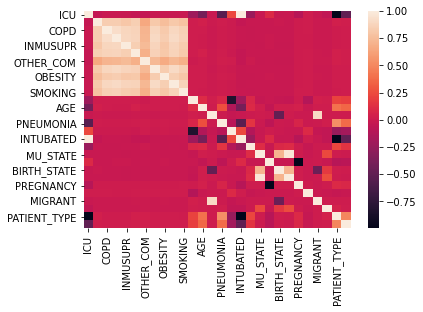

In [28]:
import seaborn
seaborn.heatmap(corr)

In [29]:
df.head()

,ICU,DIABETES,COPD,ASTHMA,INMUSUPR,HYPERTENSION,OTHER_COM,CARDIOVASCULAR,OBESITY,CHRONIC_KIDNEY,...,SPEAK_NATIVE_LANGUE,MIGRANT,COUNTRY_NATIONALITY,COUNTRY_ORIGIN,RES_MUNICIPALITY,SYMPTOM_DATE,DECEASED_DATE,PATIENT_TYPE,ENTRY_DATE,DECEASED
0,0,1,0,0,0,1,0,1,0,0,...,0,99,México,99,6,2020-04-13,2020-04-22,1,2020-04-13,1
1,97,0,0,0,0,0,0,0,0,0,...,0,99,México,99,37,2020-04-20,9999-99-99,0,2020-04-30,0
2,97,0,0,0,0,0,0,0,0,0,...,0,99,México,99,4,2020-04-19,9999-99-99,0,2020-04-19,0
3,0,0,0,0,0,0,0,0,1,0,...,0,99,México,99,4,2020-04-18,9999-99-99,1,2020-04-23,0
4,0,0,0,0,0,1,0,0,1,0,...,0,99,México,99,10,2020-05-03,9999-99-99,1,2020-05-04,0


## We shouldn't try to calculate pearson's correlation coeficient between binary variables.

### Instead we should use some similarity measures specific for binary vectors.

Here are some measures proposed in several scientific papers.

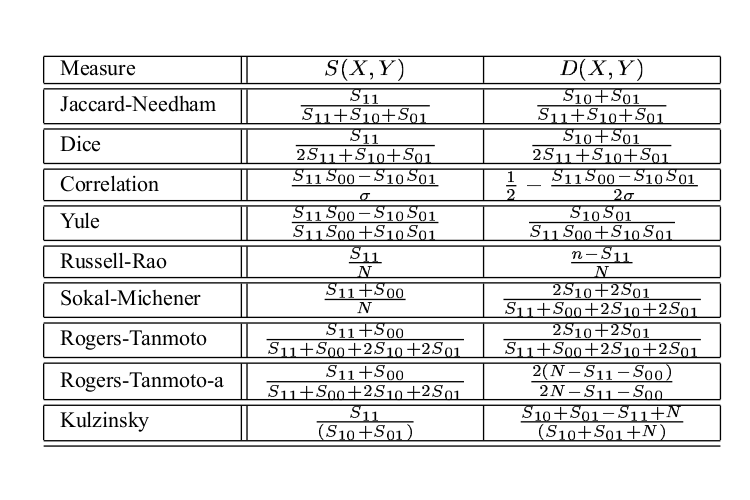

In [118]:
from IPython.display import Image
Image('binary_similarity_measures.png')

# The following image was taken from ''Properties of Binary Vector Dissimilarity Measures''
#  by Bin Zhang and Sargur N. Srihari, 

 Where $S_{ij}$  is the number of matches between $i$ and $j$ where $i$ in $X$ and $j$ in $Y$ at the corresponding positions, ($i,j \in \{0,1\}$)  

In [163]:
def counters(X,Y):
    Z = np.ones(len(X))
    S_11_bool = (X+Y) == 2
    S_00_bool = (X+Y) == 0
    S_10_bool = (X-Y) == 1
    S_01_bool = (X-Y) == -1
    
    S_X1 = Z[X==1].sum()
    S_Y1 = Z[Y==1].sum()
    S_11 = Z[S_11_bool].sum()
    S_00 = Z[S_00_bool].sum()
    S_10 = Z[S_10_bool].sum()
    S_01 = Z[S_01_bool].sum()    
    return [S_X1, S_Y1, S_11, S_00, S_10, S_01]

def correlation(X,Y):
    S_X1, S_Y1, S_11, S_00, S_10, S_01 = counters(X,Y)
    return (S_11*S_00-S_10*S_01)/max(1,math.sqrt((S_11+S_10)*(S_11+S_01)*(S_00+S_01)*(S_00+S_10)))  

def jaccard(X,Y):
    S_X1, S_Y1, S_11, S_00, S_10, S_01 = counters(X,Y)
    return (S_11)/max(1,(S_10+S_01+S_11))

def kulzinsky(X,Y):
    S_X1, S_Y1, S_11, S_00, S_10, S_01 = counters(X,Y) 
    return S_11/max(1,S_10+S_01)    

def absolute(X,Y):
    S_X1, S_Y1, S_11, S_00, S_10, S_01 = counters(X,Y)
    return S_11
    

In [38]:
columns_binary = ['ICU', 'DIABETES', 'COPD', 'ASTHMA', 'INMUSUPR', 'HYPERTENSION',
         'OTHER_COM', 'CARDIOVASCULAR', 'OBESITY', 'CHRONIC_KIDNEY', 'SMOKING',
         'OTHER_CASE', 'NATIONALITY', 'PNEUMONIA', 'INTUBATED', 'USMER_ORIGIN', 
         'SEX', 'PREGNANCY', 'SPEAK_NATIVE_LANGUE', 'MIGRANT', 'PATIENT_TYPE', 'DECEASED']

In [39]:
df_binary = df.loc[:,columns_binary]

In [146]:
df_binary.head()

,ICU,DIABETES,COPD,ASTHMA,INMUSUPR,HYPERTENSION,OTHER_COM,CARDIOVASCULAR,OBESITY,CHRONIC_KIDNEY,...,NATIONALITY,PNEUMONIA,INTUBATED,USMER_ORIGIN,SEX,PREGNANCY,SPEAK_NATIVE_LANGUE,MIGRANT,PATIENT_TYPE,DECEASED
0,0,1,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,99,1,1
1,97,0,0,0,0,0,0,0,0,0,...,1,0,97,0,0,97,0,99,0,0
2,97,0,0,0,0,0,0,0,0,0,...,1,0,97,0,0,97,0,99,0,0
3,0,0,0,0,0,0,0,0,1,0,...,1,1,1,0,1,0,0,99,1,0
4,0,0,0,0,0,1,0,0,1,0,...,1,1,0,0,1,0,0,99,1,0


In [137]:
def compare_factors_column(data, measure, column):
    values = SSD.cdist(data.T, data.T, metric=measure)
    result = pd.DataFrame(values, columns=df_binary.columns, index=df_binary.columns)
    return result[column]

In [145]:
kulzinsky_result = compare_factors_column(df_binary, kulzinsky, 'ICU')
kulzinsky_result

ICU                    1.000000
DIABETES               0.070912
COPD                   0.023257
ASTHMA                 0.016965
INMUSUPR               0.019212
HYPERTENSION           0.069673
OTHER_COM              0.021363
CARDIOVASCULAR         0.030412
OBESITY                0.079003
CHRONIC_KIDNEY         0.024726
SMOKING                0.040652
OTHER_CASE             0.099185
NATIONALITY            0.080991
PNEUMONIA              0.107857
INTUBATED              0.311244
USMER_ORIGIN           0.070831
SEX                    0.064803
PREGNANCY              0.014941
SPEAK_NATIVE_LANGUE    0.015855
MIGRANT                0.166667
PATIENT_TYPE           0.081178
DECEASED               0.098736
Name: ICU, dtype: float64

In [157]:

correlation_result = compare_factors_column(df_binary, correlation, 'ICU')
absolute_result = compare_factors_column(df_binary, absolute, 'ICU')
jaccard_result = compare_factors_column(df_binary, jaccard, 'ICU' ) 
dice_result = compare_factors_column(df_binary, 'dice', 'ICU') # this returns a dissimilarity value
dice_result = 1 - dice_result # changing values to make it a similarity value

frame = { 'jaccard': jaccard_result, 'kulzinsky': kulzinsky_result, 
        'correlation': correlation_result, 'absolute': absolute_result,
        'dice': dice_result} 

comparison_methods = pd.DataFrame(frame)
comparison_methods.sort_values('jaccard', ascending = False)



,jaccard,kulzinsky,correlation,absolute,dice
ICU,1.000000,1.000000,1.000000,11364.0,1.000000
INTUBATED,0.311244,0.311244,0.425811,5946.0,0.983935
MIGRANT,0.166667,0.166667,0.061935,15.0,0.862928
PNEUMONIA,0.107857,0.107857,0.141607,9978.0,0.099167
OTHER_CASE,0.099185,0.099185,-0.015026,2762.0,0.722321
DECEASED,0.098736,0.098736,0.079683,5669.0,0.053242
PATIENT_TYPE,0.081178,0.081178,0.000000,11364.0,0.041873
NATIONALITY,0.080991,0.080991,-0.013251,11319.0,0.862349
OBESITY,0.079003,0.079003,0.035971,3287.0,0.279723
DIABETES,0.070912,0.070912,0.005658,3798.0,0.182530


# Let's do the same analysis by State

In [192]:
def get_top_factors_related(data,measure,column):
    measure_result = compare_factors_column(data, measure, column)
    top_factors = measure_result.sort_values(ascending=False).reset_index().reset_index()
    top_factors = top_factors['index'][1:6] 
    return top_factors

In [90]:
df_binary_with_state = df.loc[:, columns_binary+['MU_STATE']]

In [91]:
data_group_by_state = df_binary_with_state.groupby('MU_STATE')

In [188]:
states_of_mexico = ['AGUASCALIENTES', 'BAJA CALIFORNIA', 'BAJA CALIFORNIA SUR', 'CAMPECHE',
                    'COAHUILA DE ZARAGOZA', 'COLIMA', 'CHIAPAS', 'CHIHUAHUA', 'CIUDAD DE MÉXICO',
                    'DURANGO', 'GUANAJUATO', 'GUERRERO', 'HIDALGO', 'JALISCO', 'MÉXICO',
                    'MICHOACÁN DE OCAMPO', 'MORELOS', 'NAYARIT', 'NUEVO LEÓN', 'OAXACA', 
                    'PUEBLA', 'QUERÉTARO', 'QUINTANA ROO', 'SAN LUIS POTOSÍ', 'SINALOA',
                    'SONORA', 'TABASCO', 'TAMAULIPAS', 'TLAXCALA', 'VERACRUZ', 'YUCATÁN',
                    'ZACATECAS']
data_states = []
for state, data_state in data_group_by_state:
        data_states.append(data_state.reset_index(drop=True).drop('MU_STATE', axis=1))

In [193]:
factors_related = pd.DataFrame()
for i, data_state in enumerate(data_states):
    top_factors = get_top_factors_related(data_state, kulzinsky, 'ICU')
    factors_related[states_of_mexico[i]] = top_factors
    

In [194]:
factors_related

,AGUASCALIENTES,BAJA CALIFORNIA,BAJA CALIFORNIA SUR,CAMPECHE,COAHUILA DE ZARAGOZA,COLIMA,CHIAPAS,CHIHUAHUA,CIUDAD DE MÉXICO,DURANGO,...,QUINTANA ROO,SAN LUIS POTOSÍ,SINALOA,SONORA,TABASCO,TAMAULIPAS,TLAXCALA,VERACRUZ,YUCATÁN,ZACATECAS
1,INTUBATED,INTUBATED,INTUBATED,MIGRANT,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,...,MIGRANT,INTUBATED,MIGRANT,INTUBATED,INTUBATED,INTUBATED,OTHER_CASE,INTUBATED,INTUBATED,PNEUMONIA
2,OTHER_CASE,OTHER_CASE,DECEASED,PNEUMONIA,OTHER_CASE,USMER_ORIGIN,MIGRANT,PNEUMONIA,MIGRANT,PNEUMONIA,...,INTUBATED,DECEASED,OTHER_CASE,DECEASED,DECEASED,PNEUMONIA,PNEUMONIA,PNEUMONIA,MIGRANT,OBESITY
3,DECEASED,OTHER_COM,OTHER_CASE,USMER_ORIGIN,PNEUMONIA,PNEUMONIA,PNEUMONIA,MIGRANT,DECEASED,DECEASED,...,DECEASED,OTHER_CASE,INTUBATED,PNEUMONIA,OTHER_CASE,OTHER_CASE,NATIONALITY,USMER_ORIGIN,PNEUMONIA,USMER_ORIGIN
4,NATIONALITY,SMOKING,OBESITY,PATIENT_TYPE,OBESITY,DECEASED,USMER_ORIGIN,PATIENT_TYPE,PNEUMONIA,OTHER_CASE,...,PNEUMONIA,PNEUMONIA,PNEUMONIA,OTHER_CASE,OBESITY,DECEASED,PATIENT_TYPE,DECEASED,OTHER_CASE,INTUBATED
5,PATIENT_TYPE,DECEASED,PNEUMONIA,NATIONALITY,DECEASED,PATIENT_TYPE,OTHER_CASE,NATIONALITY,OTHER_CASE,NATIONALITY,...,USMER_ORIGIN,HYPERTENSION,PATIENT_TYPE,USMER_ORIGIN,HYPERTENSION,NATIONALITY,OBESITY,NATIONALITY,OBESITY,PATIENT_TYPE


In [196]:
factors_related.iloc[:,9:22]

,DURANGO,GUANAJUATO,GUERRERO,HIDALGO,JALISCO,MÉXICO,MICHOACÁN DE OCAMPO,MORELOS,NAYARIT,NUEVO LEÓN,OAXACA,PUEBLA,QUERÉTARO
1,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,INTUBATED,MIGRANT
2,PNEUMONIA,DECEASED,DECEASED,DECEASED,MIGRANT,OTHER_CASE,DECEASED,COPD,OBESITY,PNEUMONIA,PNEUMONIA,DECEASED,INTUBATED
3,DECEASED,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,DECEASED,PNEUMONIA,ASTHMA,PNEUMONIA,USMER_ORIGIN,DECEASED,PNEUMONIA,OTHER_CASE
4,OTHER_CASE,USMER_ORIGIN,NATIONALITY,USMER_ORIGIN,OTHER_CASE,PNEUMONIA,OTHER_CASE,DECEASED,PATIENT_TYPE,OTHER_CASE,OBESITY,DIABETES,OBESITY
5,NATIONALITY,OTHER_CASE,PATIENT_TYPE,DIABETES,USMER_ORIGIN,OBESITY,OBESITY,PNEUMONIA,NATIONALITY,PATIENT_TYPE,OTHER_CASE,PATIENT_TYPE,INMUSUPR
